# Analyzing Data Using the FHIR Bulk Data Export API

The Bulk Data API is still very early in it's development, which you can follow here: https://github.com/smart-on-fhir/bulk-data-server.git. 

In this notebook, we'll implement a very simple client that can access and download [FHIR bulk data](http://wiki.hl7.org/index.php?title=201801_Bulk_Data) from the [Demo SMART Bulk Data Server](https://bulk-data.smarthealthit.org). This notebook is based on a [FHIR Connectathon Project](https://github.com/plangthorne/python-fhir/blob/master/demo/BulkDataDemo.ipynb) that was also set up to implement simple authentication according to [SMART Authorization Guide protocol](http://docs.smarthealthit.org/authorization/backend-services/), but we're ignoring this aspect since it's a bit technical and out of scope for this class. 

## Motivation: Generate a Data Analysis Pipeline

Creating maintainable and comprehensive pipelines for data analysis - where the process is as automated and parameterized as possible - is incredibly useful in research, with benefits including:

- rapid iteration
- reprucibility
- collaboration
- easier updates
- clarity
- debugging
- documentation
 
Also, pipelines can be used as great starting points for building more generalizable automated tools. 

To make such a pipeline for analyzing EHR data, we want to to able to write code to: 
1. Query the data source for the desired data
2. Transform this data into a format suitable for analysis
3. Analyze it with the desired data analysis software


In this tutorial, we'll demo this approach using the nascent Bulk FHIR API and Python to
1. Request the data we want to analyze from the FHIR server
2. Access and transform the data for analysis using [pandas](https://pandas.pydata.org/)

## Scenario: Patient Vaccination Analysis

Since we're currently limited to a synthetic dataset and a nascent API that's at the early stages of development, the scenario we will use is - by necessity - a bit contrived.  

We're going to focus on two specific resources - [Patients](https://www.hl7.org/fhir/patient.html) and [Immunizations](https://www.hl7.org/fhir/immunization.html) to investigate vaccination rates in our Patient pool. 

Feel free to adapt this example to your own scenario with a focus on other resources. 



## Initial Setup
1. Download and install Anaconda: https://www.anaconda.com/distribution/

2. Install the [requests](http://docs.python-requests.org/en/master/), [numpy](https://pypi.org/project/numpy/), [pandas](https://pandas.pydata.org/), and [matplotlib](https://matplotlib.org/) packages: `conda install requests pandas numpy matplotlib`.

3. Clone project from github: `git clone https://github.com/uw-fhir/bulk-fhir-tutorial.git`

4. Open `bulk-fhir-tutorial.ipynb` in JupyterLab or Jupyter Notebook

## Server Configuration

We'll start by reading required config parameters, which define the FHIR server and other options. We'll be testing against the [demo SMART Bulk Data Server](https://bulk-data.smarthealthit.org). 

In [1]:
import yaml
    
with open('config.yaml') as f:
    config = yaml.load(f)

## 1. Explore the Dataset

First, we're going to use the [SMART Patient Browser](https://patient-browser.smarthealthit.org/index.html?config=r3#/) tool to explore the patients and associated data. 

Click on the tool and play around with it a bit, clicking on the different listed [Patients](https://www.hl7.org/fhir/patient.html) and then exploring their associated FHIR Resources like [Immunizations](https://www.hl7.org/fhir/immunization.html) or [Encounters](https://www.hl7.org/fhir/encounter.html). 

## 2. Generate the Query

Now that we have a feel for the data, we need to decide what specific resources we're interested in and generate a query by using the proper [FHIR Bulk Data query parameters](https://github.com/smart-on-fhir/fhir-bulk-data-docs/blob/master/export.md#query-parameters). 

We can first try out our downloads by using a very simple tool made by the SMART folks - [The FHIR Bulk Downloader](https://bulk-data.smarthealthit.org/sample-app/index.html?server=https%3A%2F%2Fbulk-data.smarthealthit.org%2FeyJlcnIiOiIiLCJwYWdlIjoxMDAwMCwiZHVyIjoxMCwidGx0IjoxNSwibSI6MX0%2Ffhir)

We'll focus on the Patient-level export since we're only interested in data that is in some way associated with a Patient (see https://github.com/smart-on-fhir/fhir-bulk-data-docs/blob/master/export.md#query-parameters for more information), and want to download resources that will be useful for analysis. 

In this example, we'll be looking at [Immunizations](https://www.hl7.org/fhir/immunization.html). 

1. Go to [The FHIR Bulk Downloader](https://bulk-data.smarthealthit.org/sample-app/index.html?server=https%3A%2F%2Fbulk-data.smarthealthit.org%2FeyJlcnIiOiIiLCJwYWdlIjoxMDAwMCwiZHVyIjoxMCwidGx0IjoxNSwibSI6MX0%2Ffhir)

2. Select the desired resources, patient groups, and time frame. 

3. Notice how each selection modifies the download link url.

4. Try modifying the url yourself using the available query parameters, and see what happens after pressing `Download`. 
   
   For example, type this in: `https://bulk-data.smarthealthit.org/eyJlcnIiOiIiLCJwYWdlIjoxMDAwMCwiZHVyIjoxMCwidGx0IjoxNSwibSI6MX0/fhir/Patient/$export?_type=Patient,Immunization&_typeFilter=Immunization%3Fvaccine-code%3D140,Patient%3Fgender=female`
   
5. Note this generated url string for use later in the tutorial to get the desired dataset. I will be using the query above. 

## 3. Send Bulk Data Request

Now that we know what query string we'll use to access our desired dataset, we can send a request to the FHIR endpoint which will tell the endpoint to start compiling the data we require. 

In [2]:
import requests
import urllib

fhir_endpoint = config["server"]
export_level = '/Patient/$export'
types = ["Patient", "Immunization"]
typeFilters = ["Patient?gender=female", "Immunization?vaccine-code=140"]

headers = {'Accept': 'application/fhir+json', "Prefer": 'respond-async'}

payload = {'_type': ",".join(types), '_typeFilter': ",".join(typeFilters)}
payload_str = "&".join("%s=%s" % (k,v) for k,v in payload.items())
# temp
payload_str = "_type=Patient,Immunization&_typeFilter=Immunization%3Fvaccine-code%3D140,Patient%3Fgender=female"

request_url = fhir_endpoint + export_level

r = requests.get(request_url, headers=headers, params=payload_str)

display(payload_str)
display(r)
display(r.url)
display(r.json())

'_type=Patient,Immunization&_typeFilter=Immunization%3Fvaccine-code%3D140,Patient%3Fgender=female'

<Response [202]>

'https://bulk-data.smarthealthit.org/eyJlcnIiOiIiLCJwYWdlIjoxMDAwMCwiZHVyIjoxMCwidGx0IjoxNSwibSI6MX0/fhir/Patient/$export?_type=Patient,Immunization&_typeFilter=Immunization%3Fvaccine-code%3D140,Patient%3Fgender=female'

{'issue': [{'code': 'processing',
   'diagnostics': 'Your request have been accepted. You can check it\'s status at "https://bulk-data.smarthealthit.org/eyJlcnIiOiIiLCJwYWdlIjoxMDAwMCwiZHVyIjoxMCwidGx0IjoxNSwibSI6MSwidHlwZSI6IlBhdGllbnQsSW1tdW5pemF0aW9uIiwiaWQiOiJkZWRiZDg2ZjliNWNlMDQxZGIwZjc0ZGFhY2Y1M2IyZjYxNjYwZWUzNmFhMWQ0NjQwN2NhODE0NmJhZTgwOTU4IiwicmVxdWVzdFN0YXJ0IjoxNTQ5NTc1NDg5NzY5LCJzZWN1cmUiOmZhbHNlLCJvdXRwdXRGb3JtYXQiOiJuZGpzb24iLCJncm91cCI6bnVsbCwicmVxdWVzdCI6Imh0dHA6Ly9idWxrLWRhdGEuc21hcnRoZWFsdGhpdC5vcmcvZXlKbGNuSWlPaUlpTENKd1lXZGxJam94TURBd01Dd2laSFZ5SWpveE1Dd2lkR3gwSWpveE5Td2liU0k2TVgwL2ZoaXIvUGF0aWVudC8kZXhwb3J0P190eXBlPVBhdGllbnQsSW1tdW5pemF0aW9uJl90eXBlRmlsdGVyPUltbXVuaXphdGlvbiUzRnZhY2NpbmUtY29kZSUzRDE0MCxQYXRpZW50JTNGZ2VuZGVyPWZlbWFsZSJ9/fhir/bulkstatus"',
   'severity': 'information'}],
 'resourceType': 'OperationOutcome',
 'text': {'div': '<div xmlns="http://www.w3.org/1999/xhtml"><h1>Operation Outcome</h1><table border="0"><tr><td style="font-weight:bold;">informat

## 4. Wait for Data

Now that the server is compiling the datasets, we need to wait until the endpoint is ready to send the data. We continuously query the provided location until the server is done.

In [3]:
from time import sleep

def parse_manifest(response):
    return [_.get('url') for _ in response.json()['output']]

location = r.headers['Content-Location']

while True:
    sleep(0.5)
    response = requests.get(location)
    display(response.status_code)
    if response.status_code == 200:
        manifest = parse_manifest(response)
        break
    
display(manifest)

200

['https://bulk-data.smarthealthit.org/eyJlcnIiOiIiLCJwYWdlIjoxMDAwMCwiZHVyIjoxMCwidGx0IjoxNSwibSI6MSwidHlwZSI6IlBhdGllbnQsSW1tdW5pemF0aW9uIiwiaWQiOiJkZWRiZDg2ZjliNWNlMDQxZGIwZjc0ZGFhY2Y1M2IyZjYxNjYwZWUzNmFhMWQ0NjQwN2NhODE0NmJhZTgwOTU4IiwicmVxdWVzdFN0YXJ0IjoxNTQ5NTc1NDg5NzY5LCJzZWN1cmUiOmZhbHNlLCJvdXRwdXRGb3JtYXQiOiJuZGpzb24iLCJncm91cCI6bnVsbCwib2Zmc2V0IjowLCJsaW1pdCI6MTAwMDB9/fhir/bulkfiles/1.Immunization.ndjson',
 'https://bulk-data.smarthealthit.org/eyJlcnIiOiIiLCJwYWdlIjoxMDAwMCwiZHVyIjoxMCwidGx0IjoxNSwibSI6MSwidHlwZSI6IlBhdGllbnQsSW1tdW5pemF0aW9uIiwiaWQiOiJkZWRiZDg2ZjliNWNlMDQxZGIwZjc0ZGFhY2Y1M2IyZjYxNjYwZWUzNmFhMWQ0NjQwN2NhODE0NmJhZTgwOTU4IiwicmVxdWVzdFN0YXJ0IjoxNTQ5NTc1NDg5NzY5LCJzZWN1cmUiOmZhbHNlLCJvdXRwdXRGb3JtYXQiOiJuZGpzb24iLCJncm91cCI6bnVsbCwib2Zmc2V0IjowLCJsaW1pdCI6MTAwMDB9/fhir/bulkfiles/1.Patient.ndjson']

## Load and Transform the Data

Now that we have access to both the patient and immunization data, we should load the data, link patients and vaccinations together, and transform it into a form suitable for analysis. 


In [9]:
import json

def iterate_over_json(url):
    data = requests.get(url)
    for item in data.iter_lines():
        yield json.loads(item)    

json_data = list(map(iterate_over_json, manifest))

json_data


[<generator object iterate_over_json at 0x115d7f990>,
 <generator object iterate_over_json at 0x115d7fd58>]

In [10]:
import itertools as it
import numpy as np
import pandas as pd

vaccinations = pd.DataFrame(list(json_data[0]))
patients = pd.DataFrame(list(json_data[1]))

In [11]:
patients.head()

,active,address,birthDate,communication,deceasedDateTime,extension,gender,id,identifier,managingOrganization,maritalStatus,meta,multipleBirthBoolean,multipleBirthInteger,name,resourceType,telecom,text
0,NaN,[{'extension': [{'url': 'http://hl7.org/fhir/S...,1938-02-19,[{'language': {'coding': [{'system': 'urn:ietf...,2014-10-11T16:33:20+00:00,[{'url': 'http://hl7.org/fhir/us/core/Structur...,female,ddf5ae5c-5646-4a76-9efd-f7e697f3b728,[{'system': 'https://github.com/synthetichealt...,NaN,{'coding': [{'system': 'http://hl7.org/fhir/v3...,NaN,False,NaN,"[{'use': 'official', 'family': 'Pedroza', 'giv...",Patient,"[{'system': 'phone', 'value': '555-146-4994', ...","{'status': 'generated', 'div': '<div xmlns=""ht..."
1,NaN,[{'extension': [{'url': 'http://hl7.org/fhir/S...,1990-09-08,[{'language': {'coding': [{'system': 'http://i...,NaN,[{'url': 'http://hl7.org/fhir/us/core/Structur...,female,3c9a0fe6-156a-4190-ae6b-ebb6f07e52cf,[{'system': 'https://github.com/synthetichealt...,NaN,{'coding': [{'system': 'http://hl7.org/fhir/v3...,NaN,NaN,3.0,"[{'use': 'official', 'family': 'Corkery', 'giv...",Patient,"[{'system': 'phone', 'value': '555-606-9603', ...","{'status': 'generated', 'div': '<div xmlns=""ht..."
2,NaN,[{'extension': [{'url': 'http://hl7.org/fhir/S...,1971-07-09,[{'language': {'coding': [{'system': 'urn:ietf...,NaN,[{'url': 'http://hl7.org/fhir/us/core/Structur...,male,6f8f470e-07e8-4273-ad11-6e3fdc384a09,[{'system': 'https://github.com/synthetichealt...,NaN,{'coding': [{'system': 'http://hl7.org/fhir/v3...,NaN,False,NaN,"[{'use': 'official', 'family': 'Jacobi', 'give...",Patient,"[{'system': 'phone', 'value': '555-577-7481', ...","{'status': 'generated', 'div': '<div xmlns=""ht..."
3,NaN,[{'extension': [{'url': 'http://hl7.org/fhir/S...,1955-10-17,[{'language': {'coding': [{'system': 'urn:ietf...,NaN,[{'url': 'http://hl7.org/fhir/us/core/Structur...,female,f642778a-a527-4c85-b6fa-3d37745d9957,[{'system': 'https://github.com/synthetichealt...,NaN,{'coding': [{'system': 'http://hl7.org/fhir/v3...,NaN,False,NaN,"[{'use': 'official', 'family': 'Graham', 'give...",Patient,"[{'system': 'phone', 'value': '555-880-9873', ...","{'status': 'generated', 'div': '<div xmlns=""ht..."
4,NaN,[{'extension': [{'url': 'http://hl7.org/fhir/S...,1957-06-11,[{'language': {'coding': [{'system': 'urn:ietf...,NaN,[{'url': 'http://hl7.org/fhir/us/core/Structur...,male,8ada3b39-0359-4209-9b30-5fb430ad4355,[{'system': 'https://github.com/synthetichealt...,NaN,{'coding': [{'system': 'http://hl7.org/fhir/v3...,NaN,False,NaN,"[{'use': 'official', 'family': 'Bayer', 'given...",Patient,"[{'system': 'phone', 'value': '555-856-6415', ...","{'status': 'generated', 'div': '<div xmlns=""ht..."


In [12]:
vaccinations.head()

,date,encounter,id,notGiven,patient,primarySource,resourceType,status,vaccineCode
0,2005-04-23T16:33:20+00:00,{'reference': 'Encounter/0780aaee-2233-4ee2-90...,bc109526-a37d-4e28-89af-d6794e1ea5f3,False,{'reference': 'Patient/ddf5ae5c-5646-4a76-9efd...,True,Immunization,completed,{'coding': [{'system': 'http://hl7.org/fhir/si...
1,2006-04-29T16:33:20+00:00,{'reference': 'Encounter/1c093c58-6f5f-4da6-8d...,2334bd5e-0af2-417c-bb35-e70646a1d7ac,False,{'reference': 'Patient/ddf5ae5c-5646-4a76-9efd...,True,Immunization,completed,{'coding': [{'system': 'http://hl7.org/fhir/si...
2,2007-05-05T16:33:20+00:00,{'reference': 'Encounter/6f388fcc-a351-4c8e-a9...,2cb6d8c4-e385-415d-b413-ec407a768df3,False,{'reference': 'Patient/ddf5ae5c-5646-4a76-9efd...,True,Immunization,completed,{'coding': [{'system': 'http://hl7.org/fhir/si...
3,2008-05-10T16:33:20+00:00,{'reference': 'Encounter/f6d6b816-4b28-4f2a-94...,1b31e6bb-b457-4260-8d9c-bb1126129692,False,{'reference': 'Patient/ddf5ae5c-5646-4a76-9efd...,True,Immunization,completed,{'coding': [{'system': 'http://hl7.org/fhir/si...
4,2009-05-16T16:33:20+00:00,{'reference': 'Encounter/4b7fd5e7-31c0-4637-b2...,1ed98a36-9dd1-4776-a0b4-d7dea2616d10,False,{'reference': 'Patient/ddf5ae5c-5646-4a76-9efd...,True,Immunization,completed,{'coding': [{'system': 'http://hl7.org/fhir/si...


In [17]:
# TODO: merge the data, and then aggreagate to get count of immunizations that were performed for each patient. 

# Finally, create a plot bar chart of patient flu immunizations by age, or % of patients above a given age who were vaccinated this year

# Then, We can connect it to the next section - SoF - by showing 

def clean_vaccination(row):
    # Re-order Rows
    outrow = row[['id', 'date', 'patient', 'status', 'vaccineCode']]
    # Extract nested patient id
    outrow['patient'] = outrow['patient']['reference'].split('/')[1]
    #print(row['patient'])
    # Extract nested code value
    outrow['vaccineCode'] = int(outrow['vaccineCode']['coding'][0]['code'])
    return(outrow)

def clean_patient(row):
    # Select only a couple columns for simplicity and reorder them
    outrow = row[['id', 'name', 'birthDate', 'gender', 'maritalStatus']]
    address = row['address'][0]
    name = row['name'][0]
    
    outrow['name'] = f"{name['family']}, {name['given'][0]}"
    
    outrow['address'] = f"{address['city']}, {address['state']} {address['postalCode'] if ('postalCode' in address) else '' }"
    outrow['maritalStatus'] = outrow['maritalStatus']['text'] if not pd.isna(outrow['maritalStatus']) else ""
    return(outrow)


clean_vaccinations = vaccinations[1:1000].apply(clean_vaccination), result_type='expand', axis=1)
clean_patients = patients.apply(clean_patient, result_type='expand', axis = 1)

clean_patients.head()

KeyError: ("None of [['id', 'date', 'patient', 'status', 'vaccineCode']] are in the [index]", 'occurred at index date')

In [15]:
clean_vaccinations.head()

NameError: name 'clean_vaccinations' is not defined

In [50]:
# Merge
merged = pd.merge(clean_patients, clean_vaccinations, left_on='id', right_on='patient')
merged.head()

,id_x,name,birthDate,gender,maritalStatus,address,id_y,date,patient,status,vaccineCode
0,ddf5ae5c-5646-4a76-9efd-f7e697f3b728,"Pedroza, Adriana",1938-02-19,female,M,"Westborough, Massachusetts 01581",2334bd5e-0af2-417c-bb35-e70646a1d7ac,2006-04-29T16:33:20+00:00,ddf5ae5c-5646-4a76-9efd-f7e697f3b728,completed,140
1,ddf5ae5c-5646-4a76-9efd-f7e697f3b728,"Pedroza, Adriana",1938-02-19,female,M,"Westborough, Massachusetts 01581",2cb6d8c4-e385-415d-b413-ec407a768df3,2007-05-05T16:33:20+00:00,ddf5ae5c-5646-4a76-9efd-f7e697f3b728,completed,140
2,ddf5ae5c-5646-4a76-9efd-f7e697f3b728,"Pedroza, Adriana",1938-02-19,female,M,"Westborough, Massachusetts 01581",1b31e6bb-b457-4260-8d9c-bb1126129692,2008-05-10T16:33:20+00:00,ddf5ae5c-5646-4a76-9efd-f7e697f3b728,completed,140
3,ddf5ae5c-5646-4a76-9efd-f7e697f3b728,"Pedroza, Adriana",1938-02-19,female,M,"Westborough, Massachusetts 01581",1ed98a36-9dd1-4776-a0b4-d7dea2616d10,2009-05-16T16:33:20+00:00,ddf5ae5c-5646-4a76-9efd-f7e697f3b728,completed,140
4,ddf5ae5c-5646-4a76-9efd-f7e697f3b728,"Pedroza, Adriana",1938-02-19,female,M,"Westborough, Massachusetts 01581",f996812e-df39-4298-9578-0745e3f9741e,2009-05-16T16:33:20+00:00,ddf5ae5c-5646-4a76-9efd-f7e697f3b728,completed,113


In [63]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

merged['age'] = merged['birthDate'].apply(lambda birthDate: relativedelta(datetime.today(), datetime.strptime(birthDate, '%Y-%m-%d')).years) 

merged.head()

,id_x,name,birthDate,gender,maritalStatus,address,id_y,date,patient,status,vaccineCode,age
0,ddf5ae5c-5646-4a76-9efd-f7e697f3b728,"Pedroza, Adriana",1938-02-19,female,M,"Westborough, Massachusetts 01581",2334bd5e-0af2-417c-bb35-e70646a1d7ac,2006-04-29T16:33:20+00:00,ddf5ae5c-5646-4a76-9efd-f7e697f3b728,completed,140,80
1,ddf5ae5c-5646-4a76-9efd-f7e697f3b728,"Pedroza, Adriana",1938-02-19,female,M,"Westborough, Massachusetts 01581",2cb6d8c4-e385-415d-b413-ec407a768df3,2007-05-05T16:33:20+00:00,ddf5ae5c-5646-4a76-9efd-f7e697f3b728,completed,140,80
2,ddf5ae5c-5646-4a76-9efd-f7e697f3b728,"Pedroza, Adriana",1938-02-19,female,M,"Westborough, Massachusetts 01581",1b31e6bb-b457-4260-8d9c-bb1126129692,2008-05-10T16:33:20+00:00,ddf5ae5c-5646-4a76-9efd-f7e697f3b728,completed,140,80
3,ddf5ae5c-5646-4a76-9efd-f7e697f3b728,"Pedroza, Adriana",1938-02-19,female,M,"Westborough, Massachusetts 01581",1ed98a36-9dd1-4776-a0b4-d7dea2616d10,2009-05-16T16:33:20+00:00,ddf5ae5c-5646-4a76-9efd-f7e697f3b728,completed,140,80
4,ddf5ae5c-5646-4a76-9efd-f7e697f3b728,"Pedroza, Adriana",1938-02-19,female,M,"Westborough, Massachusetts 01581",f996812e-df39-4298-9578-0745e3f9741e,2009-05-16T16:33:20+00:00,ddf5ae5c-5646-4a76-9efd-f7e697f3b728,completed,113,80


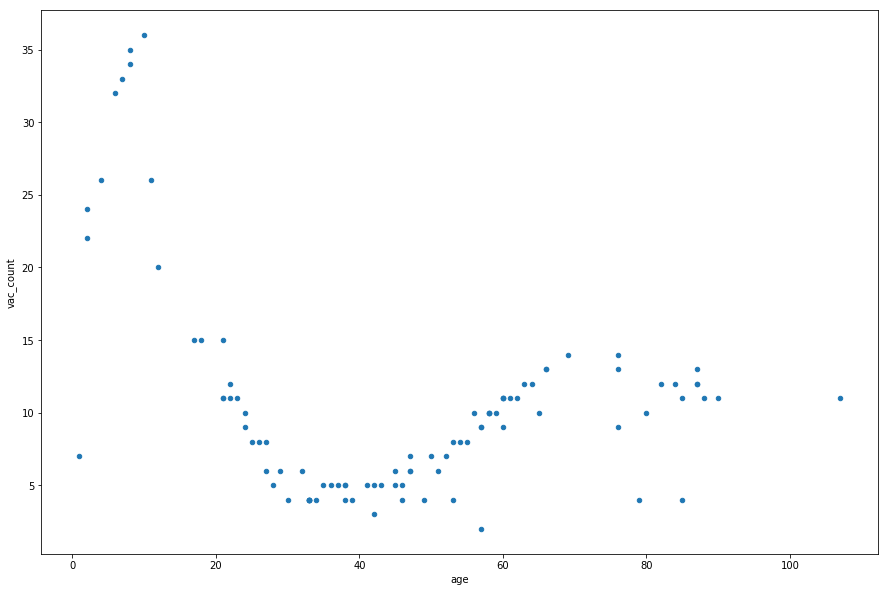

In [99]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]


agg = merged.groupby(['patient', 'age']).count()['vaccineCode']

plot_df = pd.DataFrame({'age': list(agg.index.get_level_values(1)), 'vac_count': agg}) 

plot_df.head()

plot_df.plot.scatter(x='age', y='vac_count')


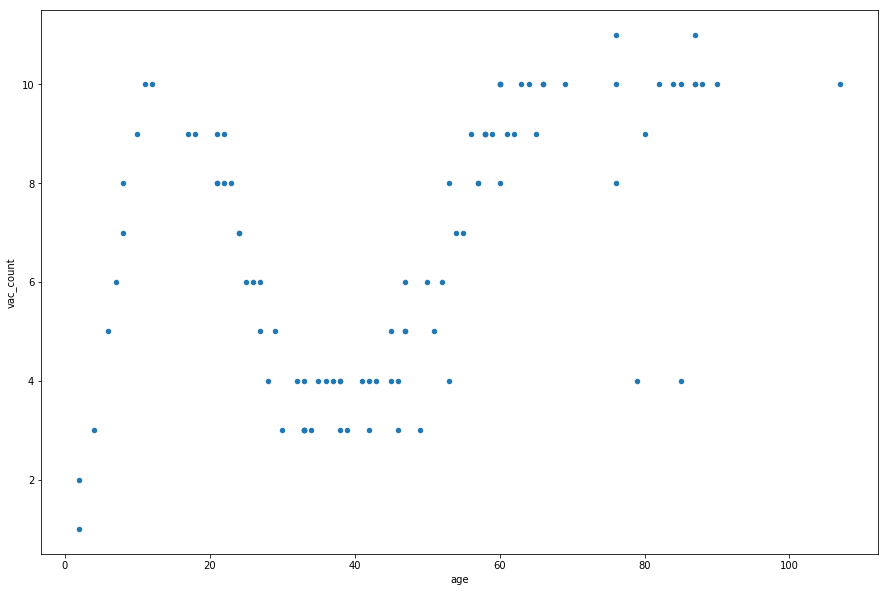

In [100]:
agg = merged[merged.vaccineCode == 140].groupby(['patient', 'age']).count()['vaccineCode']

plot_df = pd.DataFrame({'age': list(agg.index.get_level_values(1)), 'vac_count': agg}) 

plot_df.head()

plot_df.plot.scatter(x='age', y='vac_count')

## Role in a Learning Health System

Basically, sum up the results, suggest that we might want to present them at the point of care 

(Patient can be motivated to get a shot by how many people have had it, for example)

Yeah, that would be useful, and Pascal will now tell us how another related standard - SMART on FHIR - can enable this type of feedback at the point of care